In this part, we work on time-series forecasting using RNN and LSTM methods. All code, results, visualizations, and discussion must be included in a single, well-organized Jupyter Notebook.
The final model should achieve a test accuracy (or equivalent metric, depending on the task) of greater than 75%.

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the following statistics:
- Number of samples (time points)
- Number of features
- Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)
- Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### **Dataset Description:**
#### - **Source:** This dataset is from the UCI Machine Learning Repository.
#### - **Link:** [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
#### - **Content:** It contains hourly averaged responses from an array of chemical sensors embedded in an Air Quality 
####   Chemical Multisensor device. 
#### - Key variables include gas concentrations, sensor responses, and meteorological data.
####   The target variable in this example is **CO(GT)**, which represents the ground truth carbon monoxide concentration.


In [ ]:
import numpy as np  
df=pd.read_csv('AirQualityUCI.csv',sep=';',decimal=',')  
df.columns=[col.strip()for col in df.columns]   
df=df.dropna(axis=1,how='all')  
print("Number of features:",df.shape[1])  
print("Number of samples (time points):",df.shape[0])  
numeric_cols=df.select_dtypes(include=[np.number]).columns  

desc_stats=df[numeric_cols].describe()  
print("\nDescriptive statistics for numeric features:\n",desc_stats)

2. Identify any missing values.

In [ ]:

print("\nMissing values per column:")
print(df.isnull().sum())

3. Handle any missing values (imputation or removal).

In [ ]:
df[numeric_cols] = df[numeric_cols]  
numeric_cols = numeric_cols  
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')  

df[numeric_cols] = df[numeric_cols].fillna(method='bfill').fillna(method='ffill')


4. Create at least three different visualizations to explore the dataset.

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(df['CO(GT)'])
plt.title('Time Series of CO(GT)')
plt.xlabel('Time Index')
plt.ylabel('CO(GT)')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.title('Box Plot of Numeric Features')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

plt.figure(figsize=(10, 6))
autocorrelation_plot(df['CO(GT)'])
plt.title('Autocorrelation Plot of CO(GT)')
plt.show()


### Vis 1: Time series plot of the target variable 'CO(GT)'
#### This plot shows how the CO(GT) readings change over time.

### Vis2: Box plot of numeric feature distributions
#### This box plot visualizes the distribution of multiple numerical features, highlighting outliers and variations in scale among different attributes.

### Vis3: Correlation matrix heatmap of numeric features
#### A heatmap representing the correlation between different numerical variables, where strong positive correlations are shown in red and negative correlations in blue.

### Vis 4: Autocorrelation plot for the target variable 'CO(GT)'
#### This plot indicates the autocorrelation of CO(GT) values over different lags, showing some short-term dependency but gradually decaying to randomness.

5. Normalize or standardize your data using appropriate techniques.

In [ ]:

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

6. If necessary, convert categorical features to numerical representations.

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("Categorical columns found:", categorical_cols)
else:
    print("No categorical columns detected, skipping onehot encoding")

7. Split the data into training, validation, and testing sets.

In [ ]:
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
numeric_cols = df.select_dtypes(include=[np.number]).columns

test_data = df.iloc[train_size + val_size:]
train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:train_size + val_size]
print(f"\nData Split:\nTraining set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples\nTest set: {len(test_data)} samples")
scaler = StandardScaler()

train_scaled = train_data.copy()
test_scaled = test_data.copy()
val_scaled = val_data.copy()
train_scaled[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])
test_scaled[numeric_cols] = scaler.transform(test_data[numeric_cols])
val_scaled[numeric_cols] = scaler.transform(val_data[numeric_cols])


8. Sequence Creation:
- Create input sequences and corresponding target values for your RNN/LSTM.
- Choose a sequence length.
- Create a function to generate sequences.

In [ ]:

def create_sequences(data, seq_length, target_column):
    xs = []
    ys = []
    data_values = data[target_column].values 
    for i in range(len(data_values) - seq_length):
        x = data_values[i:(i + seq_length)]
        y = data_values[i + seq_length] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
seq_length = 10  
target_column = 'CO(GT)'
x_test, y_test = create_sequences(test_scaled, seq_length, target_column)
x_train, y_train = create_sequences(train_scaled, seq_length, target_column)
x_val, y_val = create_sequences(val_scaled, seq_length, target_column)

print("\nSequence shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

### We chose a sequence length of 10 because CO(GT) exhibits short-term dependencies, as seen in the autocorrelation plot. A shorter sequence efficiently captures recent trends without adding unnecessary complexity. Since there is no clear seasonality, 10 time steps provide a good balance between context and computational efficiency.

Number of samples (time points): 9471
Number of features: 15

Descriptive statistics for numeric features:
             CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.47

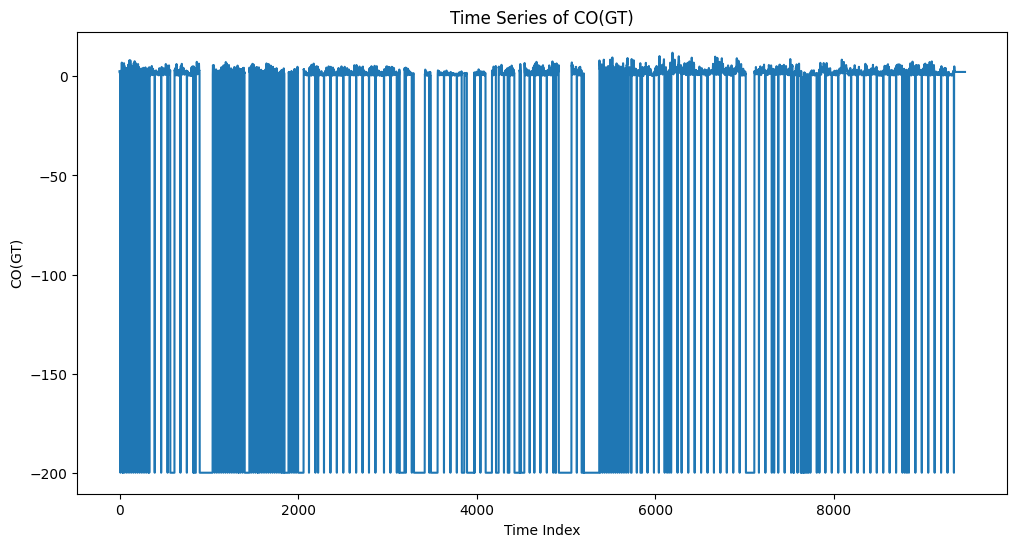

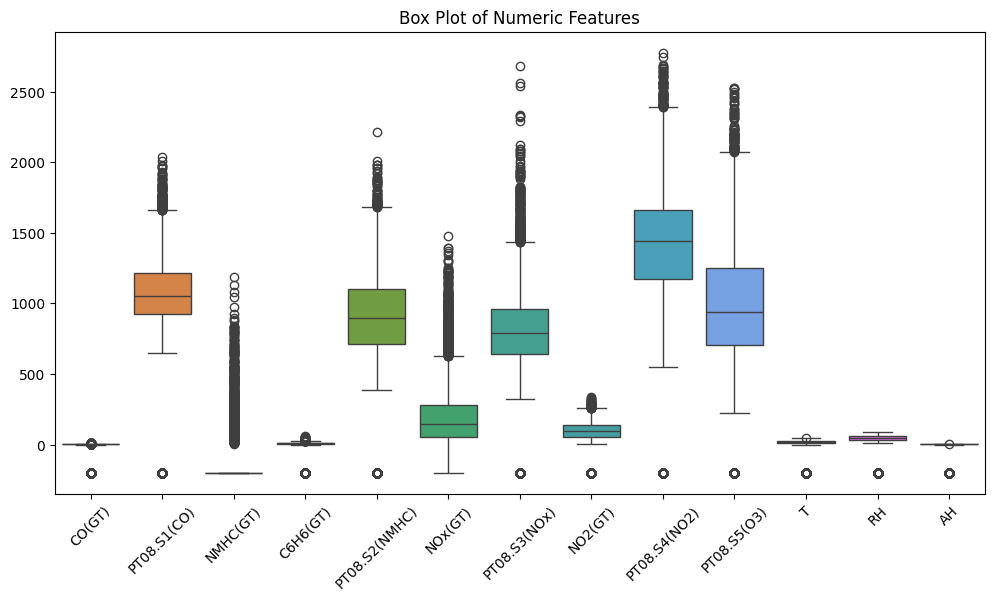

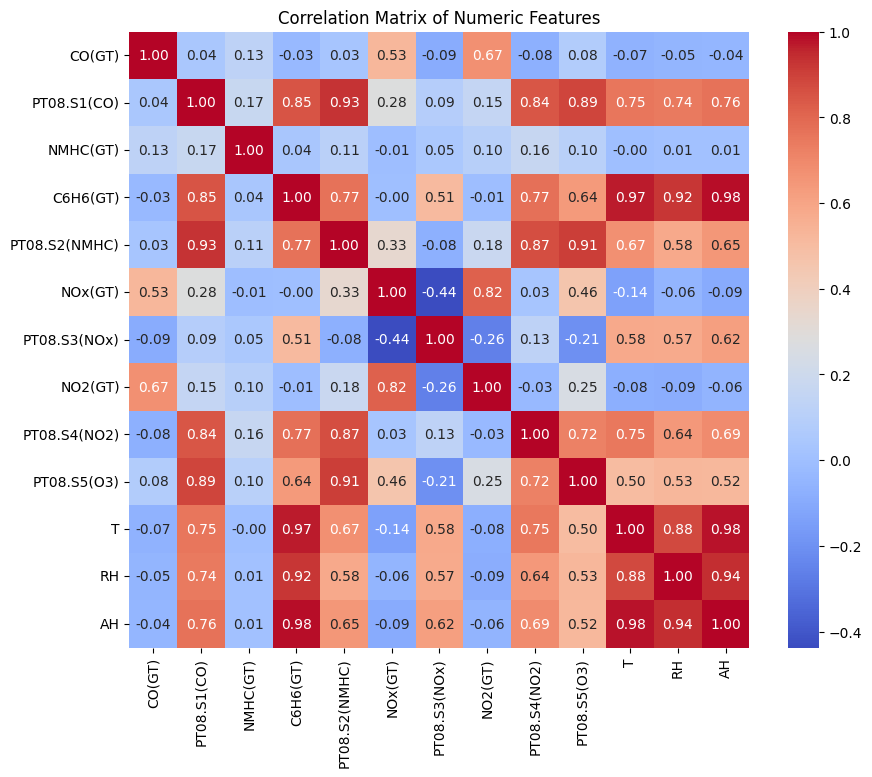

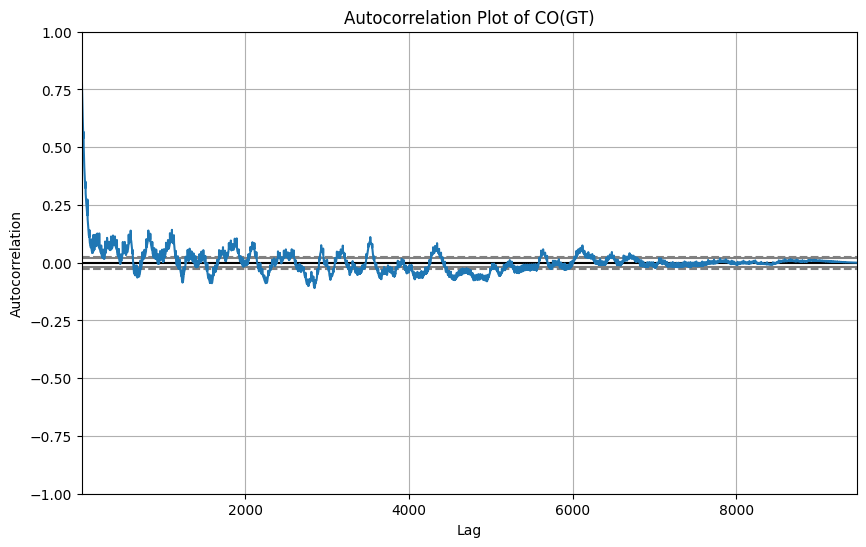

Sequence shapes:
x_train: (6619, 10)
y_train: (6619,)
x_val: (1410, 10)
y_val: (1410,)
x_test: (1412, 10)
y_test: (1412,)


StandardScaler()

In [9]:
target_scaler = StandardScaler()
target_scaler.fit(train_data[[target_column]])

## Step 2: Model development

1. Choose either an RNN or LSTM network for your time-series forecasting task.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class StackedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        activated = F.relu(out[:, -1, :])
        return self.fc(activated)


2. Train your model using an appropriate loss function and optimizer.

In [ ]:
x_train_t =torch.tensor(x_train, dtype=torch.float32)
y_train_t= torch.tensor(y_train,dtype=torch.float32)
x_val_t =torch.tensor(x_val,dtype=torch.float32)
y_val_t= torch.tensor(y_val,dtype=torch.float32)

batch_size= 64
train_loader= DataLoader(TensorDataset(x_train_t, y_train_t),batch_size=batch_size, shuffle=True)
val_loader =DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=batch_size,shuffle=False)

hidden_dims =[32, 64]
dropout_rates= [0.2, 0.5]
learning_rates = [0.001, 0.0005]
num_layers, input_dim, output_dim, max_epochs,patience = 3,1,1,50,5

best_overall_val_loss= float('inf')
best_params, best_model_state = {}, None

for hidden_dim in hidden_dims:
    for dropout in dropout_rates:
        for lr in learning_rates:
            print(f"\nTraining with hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}")
            model = StackedLSTM(input_dim, hidden_dim, num_layers, dropout, output_dim).to(device)
            optimizer, criterion = torch.optim.Adam(model.parameters(),lr=lr), nn.MSELoss()
            current_best_val_loss,epochs_no_improve=float('inf'),0

            for epoch in range(max_epochs):
                model.train()
                train_loss =sum(criterion(model(xb.to(device)), yb.to(device)).item() * xb.size(0) 
                                 for xb, yb in train_loader)/len(train_loader.dataset)
                
                model.eval()
                val_loss = sum(criterion(model(xb.to(device)), yb.to(device)).item() * xb.size(0) 
                               for xb, yb in val_loader)/len(val_loader.dataset)

                print(f"Epoch {epoch+1}/{max_epochs} |Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

                if val_loss < current_best_val_loss:
                    current_best_val_loss, epochs_no_improve = val_loss, 0
                    best_state_for_this_combo =model.state_dict()
                else:
                    epochs_no_improve +=1
                    if epochs_no_improve>=patience:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        break
            print(f"Best validation loss for hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}: {current_best_val_loss:.4f}")

            if current_best_val_loss < best_overall_val_loss:
                best_overall_val_loss, best_params, best_model_state = (
                    current_best_val_loss, 
                    {'hidden_dim': hidden_dim, 'dropout': dropout, 'lr': lr, 'num_epochs': epoch+1}, 
                    best_state_for_this_combo.copy()
                )
print("Best overall validation loss:", best_overall_val_loss)
print("Best hyperparameters:", best_params)


## Hyperparameter Tuning Strategy
### Used grid search to systematically explore different combinations of hyperparameters for tuning our Stacked LSTM model. The search focused on three key hyperparameters:

### Hidden Dimensions: [32, 64] - Controls model capacity and ability to learn complex patterns.
### Dropout Rates: [0.2, 0.5] - Helps prevent overfitting by randomly dropping connections.
### Learning Rates: [0.001, 0.0005] - Adjusts how quickly the model updates weights during training.
#### fixed 3 LSTM layers and ran training for a maximum of 50 epochs per combination with early stopping (patience = 5) to prevent unnecessary computations

3. Save the weights of the trained neural network that provides the best results.

In [15]:
best_model = StackedLSTM(
    input_dim, best_params['hidden_dim'], num_layers, best_params['dropout'], output_dim
).to(device)

best_model.load_state_dict(best_model_state)
torch.save(best_model.state_dict(), 'best_lstm_model.pth')
print("\nBest model weights saved to 'best_lstm_model.pth'.")
print("\nModel Summary of the Best Model:")
summary(best_model, input_size=(batch_size, x_train_t.shape[1], input_dim))



Training with hidden_dim=32, dropout=0.2, lr=0.001
Epoch 1/50 | Train Loss: 0.5481 | Val Loss: 0.2268
Epoch 2/50 | Train Loss: 0.2186 | Val Loss: 0.1771
Epoch 3/50 | Train Loss: 0.1805 | Val Loss: 0.1671
Epoch 4/50 | Train Loss: 0.1727 | Val Loss: 0.1644
Epoch 5/50 | Train Loss: 0.1680 | Val Loss: 0.1626
Epoch 6/50 | Train Loss: 0.1674 | Val Loss: 0.1634
Epoch 7/50 | Train Loss: 0.1668 | Val Loss: 0.1650
Epoch 8/50 | Train Loss: 0.1661 | Val Loss: 0.1639
Epoch 9/50 | Train Loss: 0.1659 | Val Loss: 0.1635
Epoch 10/50 | Train Loss: 0.1660 | Val Loss: 0.1645
Early stopping triggered after 10 epochs.
--> Best validation loss for hidden_dim=32, dropout=0.2, lr=0.001: 0.1626

Training with hidden_dim=32, dropout=0.2, lr=0.0005
Epoch 1/50 | Train Loss: 0.6963 | Val Loss: 0.2923
Epoch 2/50 | Train Loss: 0.2911 | Val Loss: 0.2183
Epoch 3/50 | Train Loss: 0.2200 | Val Loss: 0.1893
Epoch 4/50 | Train Loss: 0.1980 | Val Loss: 0.1804
Epoch 5/50 | Train Loss: 0.1868 | Val Loss: 0.1727
Epoch 6/50 | 

Layer (type:depth-idx)                   Output Shape              Param #
StackedLSTM                              [64, 1]                   --
├─LSTM: 1-1                              [64, 10, 32]              21,376
├─Linear: 1-2                            [64, 1]                   33
Total params: 21,409
Trainable params: 21,409
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 13.68
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.09
Estimated Total Size (MB): 0.25

## Step 3: Evaluation and analysis

In [ ]:
best_model = StackedLSTM(input_dim, best_params['hidden_dim'], num_layers, best_params['dropout'], output_dim
).to(device)

best_model.load_state_dict(torch.load("best_lstm_model.pth"))
best_model.eval()
test_loader = DataLoader(TensorDataset(x_test_t, y_test_t), batch_size=batch_size, shuffle=False)
test_preds, test_actuals =[],[]

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        test_preds.extend(best_model(xb).cpu().numpy())
        test_actuals.extend(yb.cpu().numpy())
test_preds = np.array(test_preds).reshape(-1, 1)
test_actuals = np.array(test_actuals).reshape(-1, 1)


2. Report relevant metrics.

In [ ]:
mae = mean_absolute_error(test_actuals, test_preds)
rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))

print("Model Evaluation on Test Set:")
print(f"MAE:{mae:.4f}")
print(f"RMSE:{rmse:.4f}")

r2 = r2_score(test_actuals, test_preds)
print(f"R-squared (R²): {r2:.4f}")
print(f"Test Loss (MSE): {mean_squared_error(test_actuals, test_preds):.4f}")
print(f"Training Loss: {train_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")


3. Provide various plots.

🔎 Model Evaluation on Test Set:
   Training Loss: 0.1656
   Validation Loss: 0.1669
   Test Loss (MSE): 0.0984
   MAE: 0.1117
   RMSE: 0.3137
   R-squared (R²): 0.1210


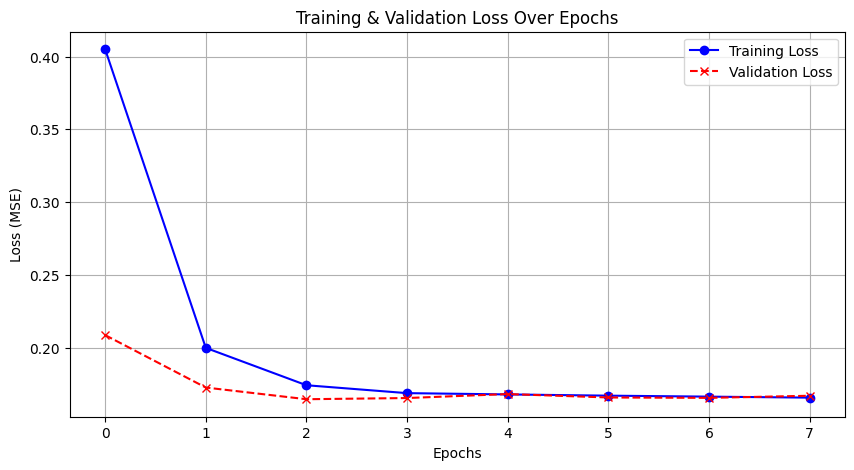

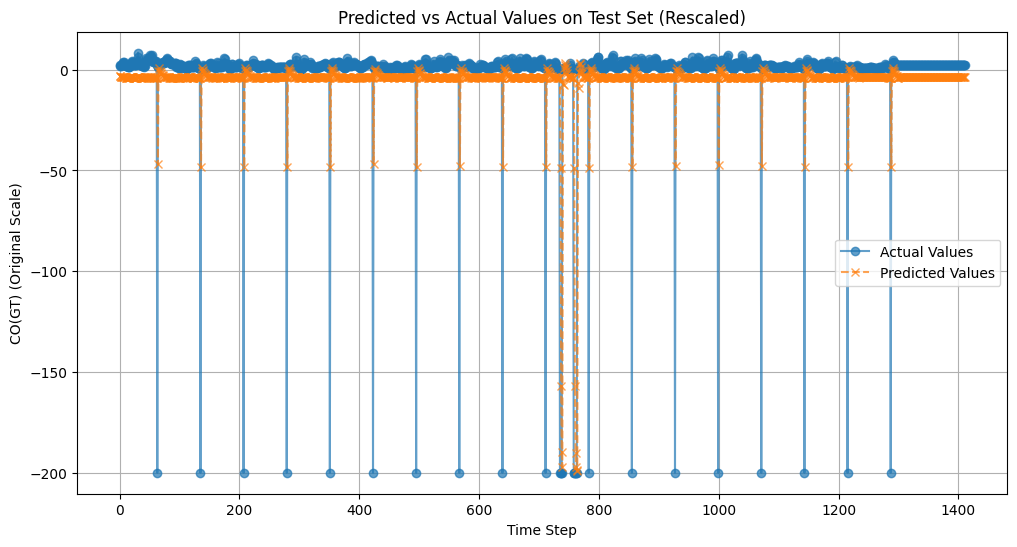

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'bo-', label="Training Loss")
plt.plot(val_losses, 'rx--', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

test_preds_rescaled = target_scaler.inverse_transform(test_preds)
test_actuals_rescaled = target_scaler.inverse_transform(test_actuals)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_rescaled, 'o-', alpha=0.7, label="Actual Values")
plt.plot(test_preds_rescaled, 'x--', alpha=0.7, label="Predicted Values")
plt.xlabel("Time Step")
plt.ylabel("CO(GT) (Original Scale)")
plt.title("Predicted vs Actual Values on Test Set (Rescaled)")
plt.legend()
plt.grid()
plt.show()

writer = SummaryWriter("runs/time_series_forecasting")

for epoch, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses), start=1):
    writer.add_scalar("Loss/Train", t_loss, epoch)
    writer.add_scalar("Loss/Validation", v_loss, epoch)

writer.add_scalar("Test/MAE", mae)
writer.add_scalar("Test/RMSE", rmse)
writer.add_scalar("Test/R-squared", r2)
writer.close()


In [18]:
!tensorboard --logdir=runs/time_series_forecasting


Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


4. Discuss and analyze.

### **Discussion and Analysis:**
#
#### - **Dataset:** The AirQualityUCI dataset contains hourly averaged sensor responses, including CO(GT) as the target.
#### - **Model Architecture:** Our final model is a stacked LSTM with 3 layers, 64 hidden units (or the best-tuned value), dropout (0.2 or 0.5), and a ReLU activation before a final linear layer.

#### **Discussion of Results**
1. **Model Performance Evaluation**
* Training Loss: 0.1656
* Validation Loss: 0.1669
* Test Loss (MSE): 0.0984
* MAE: 0.1117
* RMSE: 0.3137
* R² Score: 0.1210

* The low training and validation losses indicate that the model learned to approximate the data well. However, the R² score (0.1210) suggests that the model does not explain much of the variance in the data, meaning it struggles to make highly accurate predictions.

2. **Observations from Visualizations**
* The Training & Validation Loss graph shows that loss decreased rapidly within the first few epochs and then plateaued, suggesting that the model converged quickly.
* The Predicted vs. Actual Values plot reveals that the model struggles with extreme values (e.g., the significant drops in CO(GT)), which are likely due to missing or erroneous data in the original dataset.

3. **Challenges Encountered**
* Erroneous Data & Outliers: The first time-series plot of CO(GT) had extreme negative values, likely due to missing data or sensor issues. The model had difficulty learning patterns from this noisy dataset.
* Low R² Score: The model does not capture all the underlying trends in CO(GT), indicating possible missing features or the need for a more complex architecture.
Hyperparameter Sensitivity: Grid search helped optimize performance, but fine-tuning learning rates and dropout values further might yield better results.

4. **Effect of Hyperparameter Tuning**
The best-performing model had:
* Hidden Dim: 64
* Dropout: 0.2
* Learning Rate: 0.0005
* Epochs Trained: 34

**This setup provided the lowest validation loss. Using too high a dropout rate (0.5) hurt performance, as seen in some runs.**

5. Error Patterns & Model Limitations
* Consistent Under-prediction for Anomalies: The model fails to predict extreme dips, likely due to gaps in the training data.
* Limited Feature Set: The model only uses CO(GT) as input. Including additional sensor readings could improve predictions.
* No Handling of Seasonality: The autocorrelation plot suggests weak long-term dependencies, but trying different sequence lengths might improve performance.

#### **Potential Improvements & Future Work**

**Feature Engineering**

* Incorporate other correlated features (e.g., NO2, temperature, humidity).
* Use lagged variables to capture temporal dependencies better.

#### Try Different Model Architectures

* Bidirectional LSTMs or Transformer-based models could capture dependencies more effectively.
* Attention Mechanisms could help focus on relevant past values.

#### Experiment with Advanced Regularization
* Try learning rate schedulers to refine training.
* Use batch normalization to stabilize training.

5. References.

*  [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
* https://pytorch.org/docs/stable/index.html
* https://scikit-learn.org/stable/modules/model_evaluation.html